Бинарная классификация с классами:<br>
1. Можно судить о качестве терминала
2. Нельзя судить о качестве терминала

# Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image
import PIL
from torch.optim import lr_scheduler
import os
from sklearn.model_selection import train_test_split
import shutil
import gc
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix
from torch.utils.data import DataLoader, Dataset
from IPython.display import clear_output
from PIL import ImageFile

In [2]:
RANDOM_STATE = 42

In [3]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Подготовка датасета

In [5]:
df = pd.read_pickle('../data/common_files/df_markup.pkl')
df = df.loc[
    df['terminal']==1,
    ['file_name', 'terminal_unrecognized_defect']
]

In [6]:
df['terminal_unrecognized_defect'].value_counts()

terminal_unrecognized_defect
0    4084
1     292
Name: count, dtype: int64

In [7]:
df.head()

,file_name,terminal_unrecognized_defect
3122,..\data\sorted_data_merged\damaged\1.jpg,0
3123,..\data\sorted_data_merged\damaged\2.jpg,0
3124,..\data\sorted_data_merged\damaged\3.jpg,0
3125,..\data\sorted_data_merged\damaged\4.jpg,0
3126,..\data\sorted_data_merged\damaged\5.jpg,0


terminal_unrecognized_defect:	0


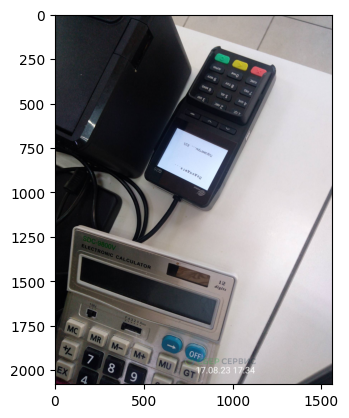

terminal_unrecognized_defect:	0


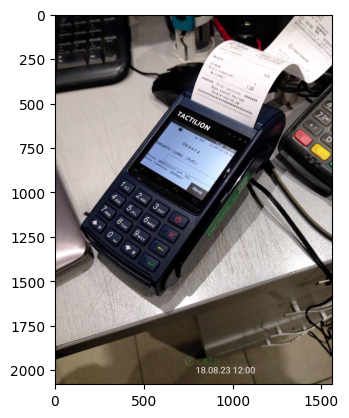

terminal_unrecognized_defect:	0


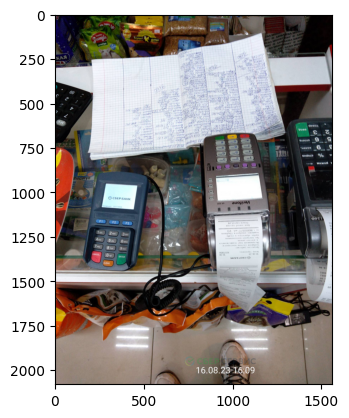

terminal_unrecognized_defect:	0


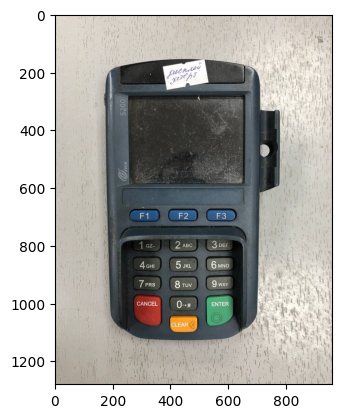

terminal_unrecognized_defect:	0


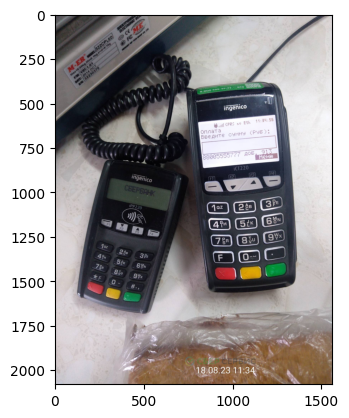

In [8]:
for row in df.sample(5).iterrows():
    row = row[1]
    img = Image.open(row['file_name'])
    print(f'terminal_unrecognized_defect:\t{row["terminal_unrecognized_defect"]}')
    plt.imshow(img)
    plt.show()

In [9]:
train_data, test_data = train_test_split(
    df, stratify=df['terminal_unrecognized_defect'], test_size=0.25, random_state=RANDOM_STATE
)

In [10]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [11]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, target_column, transform=None):
        self.data = dataframe
        self.transform = transform
        self.target_column = target_column

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = self.data.iloc[idx][self.target_column]
        img = Image.open(self.data.iloc[idx]['file_name']).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

In [12]:
NUM_WORKERS = 0 # os.cpu_count()
BATCH_SIZE = 32

train_dataset = CustomDataset(train_data, target_column='terminal_unrecognized_defect', transform=train_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

test_dataset = CustomDataset(test_data, target_column='terminal_unrecognized_defect', transform=test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

# Обучение модели

In [13]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s):
    clear_output()
    fig, axs = plt.subplots(1, 3, figsize=(20, 10))
    plt.rcParams['font.size'] = '12'
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    axs[2].plot(range(1, len(train_f1s) + 1), train_f1s, label='train')
    axs[2].plot(range(1, len(test_f1s) + 1), test_f1s, label='test')
    axs[2].set_ylabel('F1')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()
    plt.show()

def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy, f1_score_value = 0.0, 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        # Calculate F1-score
        predictions = logits.argmax(dim=1)
        f1_score_value += f1_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    f1_score_value /= len(train_loader)

    return train_loss, train_accuracy, f1_score_value


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy, test_f1 = 0.0, 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()
        # Calculate F1-score
        predictions = logits.argmax(dim=1)
        test_f1 += f1_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    test_f1 /= len(test_loader)

    return test_loss, test_accuracy, test_f1


def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies, train_f1s = [], [], []
    test_losses, test_accuracies, test_f1s = [], [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy, train_f1 = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy, test_f1 = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        train_f1s += [train_f1]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        test_f1s += [test_f1]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s)

    return train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s

In [14]:
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

model_terminal = models.mobilenet_v3_large(pretrained=True, progress=True)
model_terminal.classifier[-1] = nn.Linear(1280, 3)
model_terminal = model_terminal.to(device)

C:\Users\Dm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Dm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
num_epochs = 30

optimizer = torch.optim.SGD(model_terminal.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

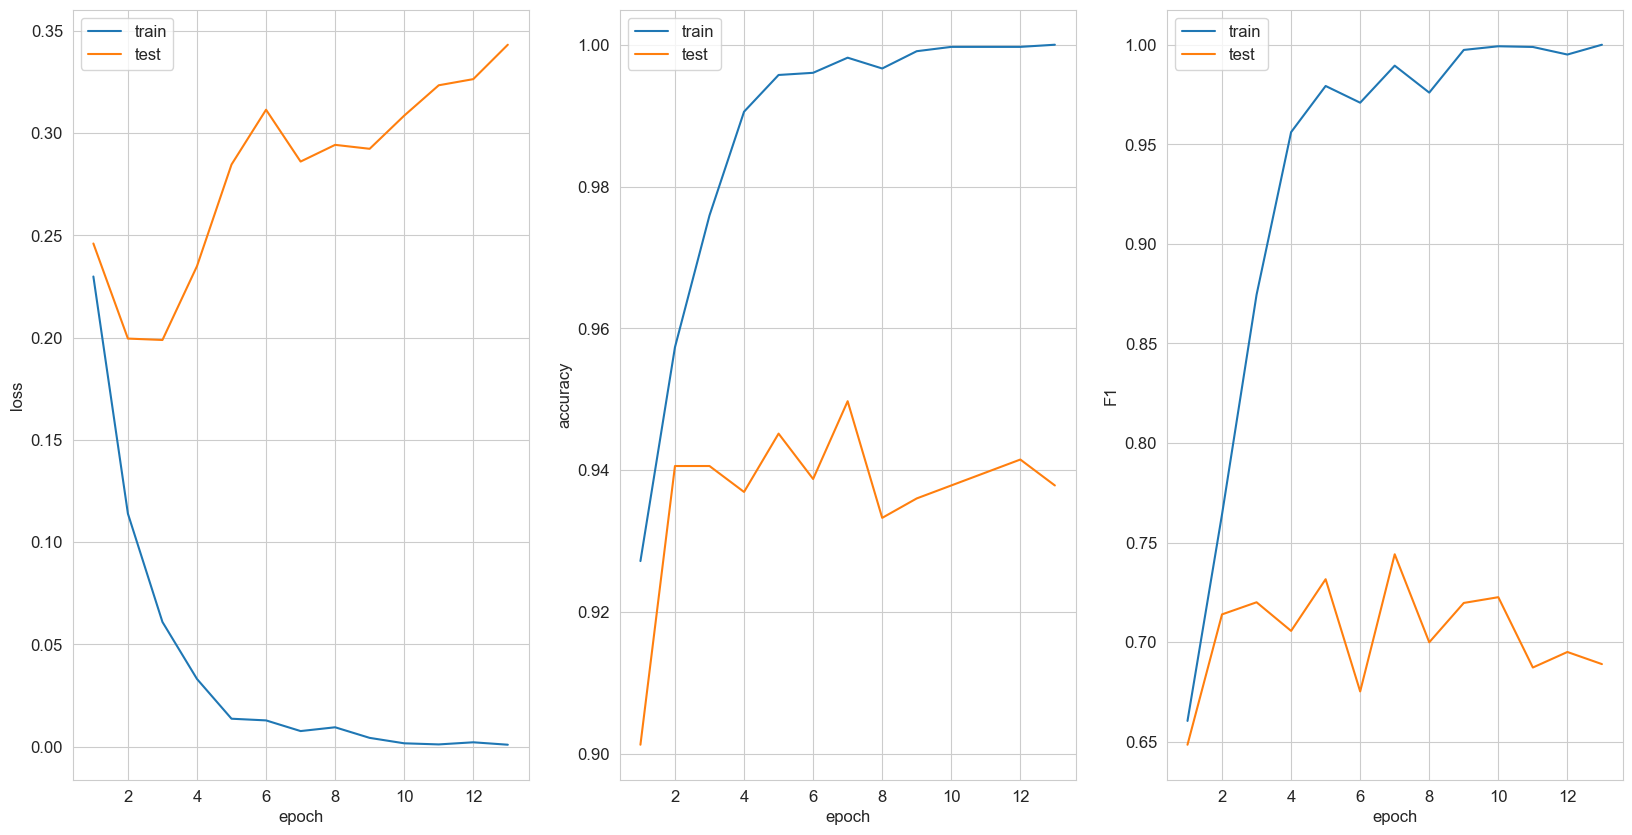

Training 14/30:   3%|▎         | 3/103 [00:02<01:31,  1.09it/s]


KeyboardInterrupt: 

In [17]:
train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s = train(
    model_terminal, optimizer, scheduler, criterion, train_dataloader, test_dataloader, num_epochs
)

In [19]:
if not os.path.exists('models'):
    os.makedirs('models')
torch.save(model_terminal, 'models/model_is_visible.pt')

# Валидация

In [14]:
model = torch.load('models/model_is_visible.pt')
model.eval()
clear_output()

In [ ]:
# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
NUM_WORKERS = 0
BATCH_SIZE = 4
test_dataset = CustomDataset(df, target_column='terminal_unrecognized_defect', transform=test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [16]:
all_labels, all_preds_terminal, all_preds_receipt = [], [], []
for images, labels in tqdm(test_dataloader):
    images = images.to(device)  # images: batch_size x num_channels x height x width

    logits_terminal = model(images)  # logits: batch_size x num_classes
    predictions_terminal = logits_terminal.argmax(dim=1)

    all_labels.append(labels)
    all_preds_terminal.append(predictions_terminal)

100%|██████████| 35/35 [00:26<00:00,  1.31it/s]


In [18]:
all_preds_terminal = [torch.Tensor.cpu(x).numpy() for x in all_preds_terminal]
df_val = pd.DataFrame({
    'labels': np.hstack(all_labels),
    'predictions_terminal': np.hstack(all_preds_terminal)
})
df_val.head()

,labels,predictions_terminal
0,0,0
1,0,0
2,0,0
3,0,1
4,1,0


In [19]:
df_val['terminal_unrecognized_defect'].value_counts()

predictions_terminal
0    1033
1      61
Name: count, dtype: int64

In [23]:
df_val['predictions_terminal'].unique()

array([0, 1], dtype=int64)

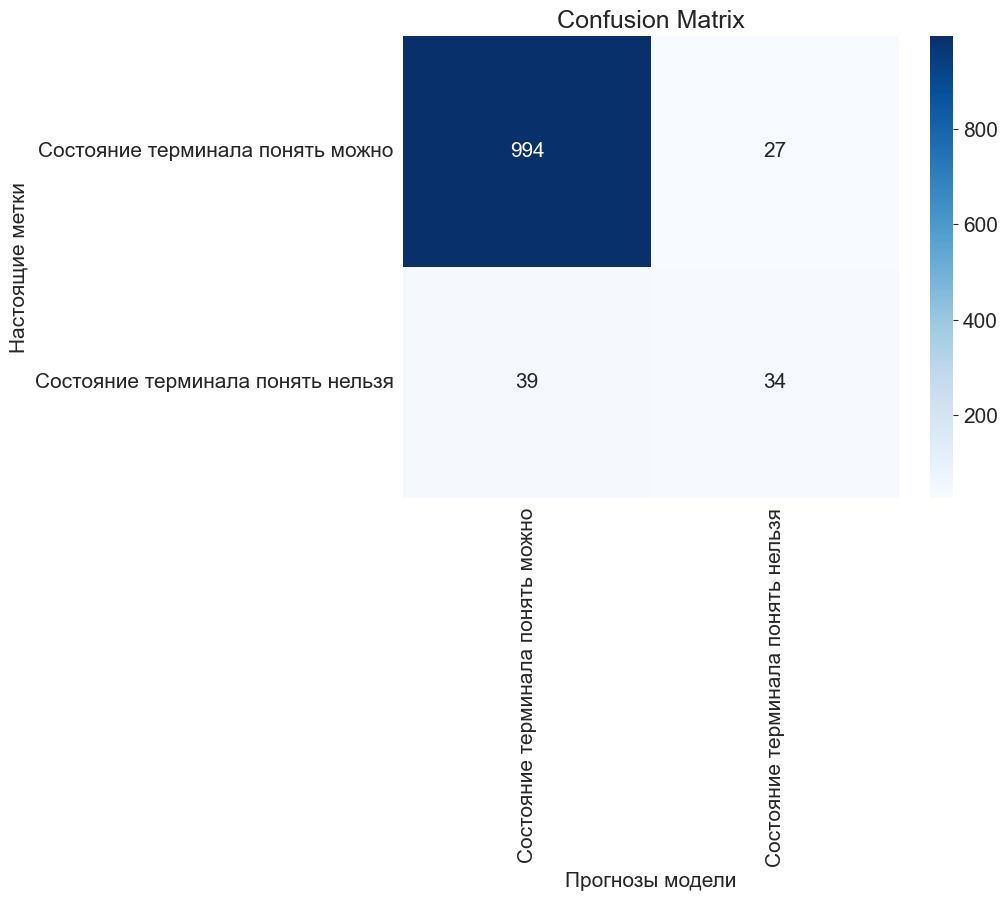

In [28]:
from sklearn.metrics import confusion_matrix

df_val = df_val[['labels', 'predictions_terminal']]
cm = confusion_matrix(
    df_val['labels'], 
    df_val['predictions_terminal'], 
    labels=[0, 1]
)

# Define class labels
class_names = ['Состояние терминала понять можно', 'Состояние терминала понять нельзя']
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Прогнозы модели')
plt.ylabel('Настоящие метки')
plt.show()

Метрики на MobileNet3Small без аугментаций

![Alt text](image.png)

![Alt text](image-1.png)